## Exploration

train.csv shape is  (555719, 23)
test.csv shape is  (69465, 2)

       Id trans_date_trans_time        cc_num  \
0  205743      01/09/2020 08:22  5.596350e+15   
1  465349      12/12/2020 07:42  4.311370e+18   
2   17312      27/06/2020 13:03  2.264940e+15   
3  234968      14/09/2020 04:12  2.224100e+15   
4  194255      28/08/2020 17:40  3.527540e+15   

                              merchant       category      amt    first  \
0                      fraud_Berge LLC  gas_transport    72.18   Joseph   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport    36.66  Phillip   
2              fraud_Ankunding-Carroll         travel     1.74     Juan   
3     fraud_Schumm, Bauch and Ondricka    grocery_pos   140.99    Sheri   
4                    fraud_Gerlach Inc   shopping_net  1722.19   Teresa   

       last gender                        street  ...      lat      long  \
0     Moody      M              5901 Foster Pine  ...  29.9912  -90.2479   
1  Delacruz      M     26678 Lisa Lock

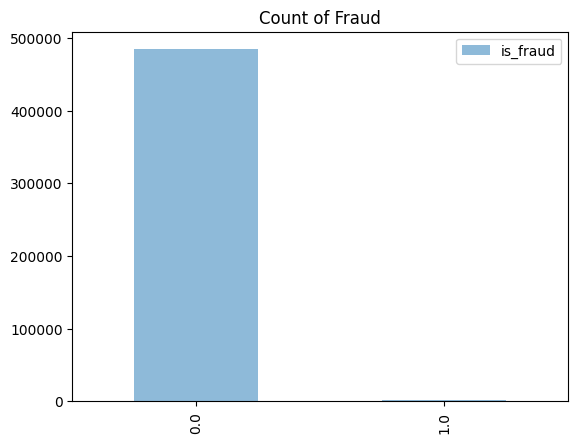

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Fraud")
plt.show()

## Feature Extraction

In [18]:
import pandas as pd

def process(df):
    # This is where you can do all your processing
    date_time = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

    df['trans_date'] = date_time.dt.date[0]
    df['trans_time'] = date_time.dt.time[0]
    df.drop(columns='trans_date_trans_time', inplace=True)

    return df

# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['is_fraud_x'])
testX = testX.rename(columns={'is_fraud_y': 'is_fraud'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['is_fraud'].notnull()]

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

## Creating your model

Index(['Id', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long'],
      dtype='object')
Accuracy on testing set =  0.9958540357342635
F1 score on testing set =  0.4760914760914761


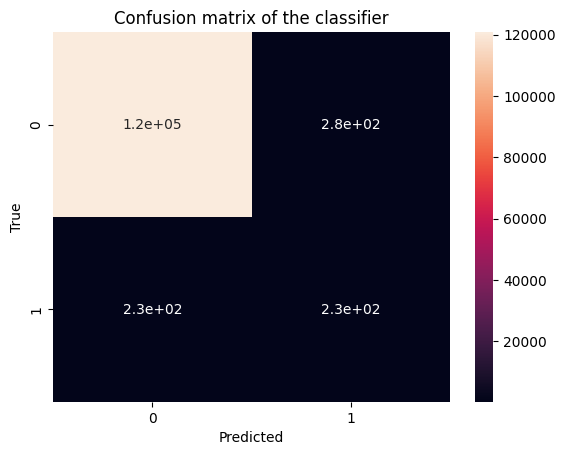

In [19]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),
        X_train['is_fraud'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train._get_numeric_data()
print(X_train_processed.columns)
X_test_processed = X_test._get_numeric_data()

# Learn the model
model = DecisionTreeClassifier().fit(X_train_processed, Y_train)

# pickle model - saves it so you can load it later
with open('knn_20_model.obj', 'wb') as f:
        pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [20]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])
print(X_submission_processed.columns)

X_submission['is_fraud'] = model.predict(X_submission_processed)
X_submission.is_fraud = X_submission.is_fraud.astype(int)
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("./data/submission.csv", index=False)

Index(['Id', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long'],
      dtype='object')


Now you can upload the `submission.csv` to kaggle